### Delta Hedging

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

On simule le prix d'un call en Black & Scholes

In [50]:
def Repartition(x):
    return (1 + math.erf(x / math.sqrt(2))) / 2

def d1(t, S, K, T, r, sigma):
    return (math.log(S / K) + (r + (sigma ** 2) / 2) * (T - t)) / (sigma * math.sqrt(T - t))

def d2(t, S, K, T, r, sigma):
    return (math.log(S / K) + (r - (sigma ** 2) / 2) * (T - t)) / (sigma * math.sqrt(T - t))

def Call_BS(t, S, K, T, r, sigma):
    if t == T:
        return max(S - K, 0)
    else:
        return S * Repartition(d1(t, S, K, T, r, sigma)) - K * math.exp(-r * (T - t)) * Repartition(d2(t, S, K, T, r, sigma))


On construit un portefeuille de couverture de facon à éliminer une partie aléatoire dans la différence entre les valeurs du portefeuille et l'option.
P&L de la stratégie de delta-couverture est mesuré par la différence entre la valeur terminale du portefeuille de la couverture et le prix de l'option à la maturité.

In [75]:
def hedging(N=100, T=5, S0=1, K=1.5,sigma=0.5, r=0.05, Nmc=5000):
    np.random_state = 0

    delta_t = T / N  
    Valeurs_PL = []

    S = np.zeros(N + 1)
    A = np.zeros(N + 1)
    B = np.zeros(N + 1) 
    t = np.zeros(N + 1)
    V = np.zeros(N + 1)
    P = np.zeros(N + 1)
    P_act = np.zeros(N + 1)
    W = np.zeros(N + 1)
    achat = np.zeros(N + 1)

    for i in range(N + 1):
        t[i] = i * delta_t

    for j in range(Nmc + 1):

        V[0] = Call_BS(0, S0, K, T, r, sigma)
        S[0] = 1
        B[0] = 1
        A[0] = Repartition(d1(0, S0, K, T, r, sigma))
        P[0] = A[0] * S[0] + B[0]
        P_act[0] = V[0]
        W[0] = A[0] * S[0] / P[0]

        for i in range(N):

            S[i + 1] = S[i] * math.exp((r - (sigma**2)/2) * delta_t + math.sqrt(delta_t) * sigma * np.random.normal(0,1)) #Prix du sous-jacent
            P[i + 1] = S[i + 1] * A[i] + B[i] * (1 + r * delta_t) # Valeur du portefeuille
            A[i + 1] = Repartition(d1(t[i + 1],S[i + 1],K,T,r,sigma)) # nombre de parts du sous-jacent
            B[i + 1] = S[i + 1] * (A[i] - A[i + 1]) + B[i] * (1 + r * delta_t) #Cash
            P_act[i + 1] = P[i + 1] - (P[0] - V[0]) * math.exp(r * t[i + 1]) # Prix actualisé
            V[i + 1] = Call_BS(t[i + 1],S[i + 1], K,T,r,sigma)#Prix de l'option
            achat[i + 1] = A[i + 1] - A[i]
            W[i + 1] = A[i + 1] * S[i + 1] / P[i + 1] #Proportion de la partie investie du portefueille

        PL = P_act[N] - V[N]
        Valeurs_PL.append(PL)

    plt.plot(t, B,label="Cash", c='r')
    plt.plot(t, A * S,label="Partie investie", c='b')
    plt.plot(t, P, label="Valeur du portefueille", c='g')
    plt.legend(loc='upper left')
    plt.show()

    plt.plot(t, P_act, label="Portefueille actualisé")
    plt.plot(t, V, label="Prix du Call")
    plt.legend()
    plt.show()
    return Valeurs_PL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


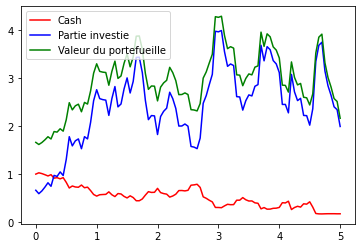

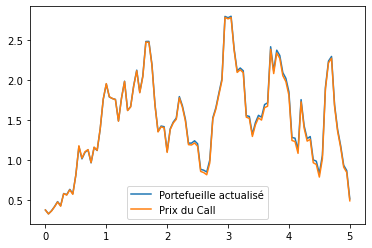

In [78]:
Valeurs_PL = hedging()


*   On remarque bien que la valeur totale du portefueille est la somme de la partie investie et la partie cash
*   On remarque également que les valeurs actualisées du portefeuille et le prix de l'option sont très proches comme on vient d'éliminer le risque

###Densité du P&L

In [79]:
def densité_PL(N=100, Nmc=5000, a=-0.3, b=0.3, Valeurs_PL=Valeurs_PL):

  densite_PL = np.zeros(N + 1)
  X = np.zeros(N + 1)
  
  delta_x = (b - a) / 100

  for j in range(N + 1):
          X[j] = a + j * delta_x
          nb = 0
          for i in range(Nmc + 1):

              if (Valeurs_PL[i]>= X[j]) and (Valeurs_PL[i]<= X[j] + delta_x):
                  nb = nb + 1

          densite_PL[j] = (nb/Nmc) / delta_x

  plt.plot(X,densite_PL)
  plt.title("Densité P&L")
  plt.show()

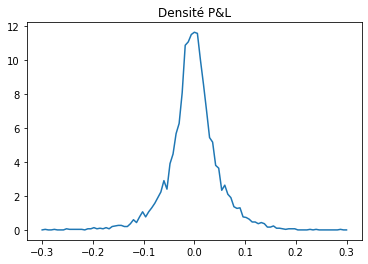

In [80]:
densité_PL()

###Fonction de répartition du P&L

In [81]:
def Repartition_PL(N=100,Nmc=5000, a=-0.3,b=0.3, Valeurs_PL=Valeurs_PL): 

  X = np.zeros(N + 1)
  Repartition_PL = np.zeros(N + 1)

  delta_x = (b - a) / 100

  for j in range(N + 1):
  
    X[j] = a + j * delta_x
    nb = 0
    for i in range(Nmc + 1):

      if Valeurs_PL[i] <= X[j]:
        nb = nb + 1
        Repartition_PL[j] = (nb / Nmc)
  plt.plot(X, Repartition_PL)
  plt.title("Répartition P&L")
  plt.show()

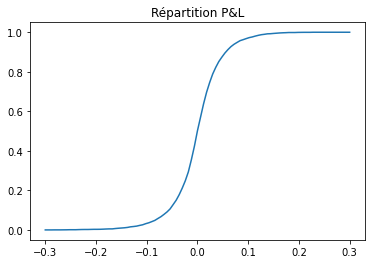

In [49]:
Repartition_PL()

Le P&L suit une loi normale

###VaR (Value at Risk)

In [82]:
Valeurs_PL.sort()
Alpha = 0.01
Nmc = 1000
VaR = Y[int(Alpha * Nmc)]
print("VaR pour Alpha=1% est :", VaR)

VaR pour Alpha=1% est : -0.007056069154129929
